# Introduction and Problem Definition

## Goal  
The goal is to predict the power generation of a solar power plant based on a given weather data.  
For the sake of experiment and simplicity, I will only use one of the 2 pairs of datasets, as the same procedure can pretty much be carried out on the other one.

## Data Acquisition

The datasets were obtained from this [link](https://www.kaggle.com/anikannal/solar-power-generation-data).  
  
They consist of 2 pairs of datasets, each contains:
- generation data of a solar power plant
- weather data  
  
  
All of this data was measured over a 34-day period with an array of sensors optimally placed at the plants. 
More information can be found by visitting the link above. 

## Problem Definition

The power generation capacity of a solar power plant is of continous data type, which means it is most ideal to use regression algorithms to estimate its values.

# Data Analysis

## Import necessary packages and load datasets

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
GEN_DATA_PATH = "./dataset/Plant_1_Generation_Data.csv"
WEATHER_DATA_PATH = './dataset/Plant_1_Weather_Sensor_Data.csv'

Let's load both of the datasets and have a peak in each one of them:

In [3]:
gen_df = pd.read_csv(GEN_DATA_PATH)
gen_df

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


In [4]:
weather_df = pd.read_csv(WEATHER_DATA_PATH)
weather_df

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0
...,...,...,...,...,...,...
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0


It is not ideal to build an estimator just from the power generation dataset, so let's join the weather dataset into this one as well to see if we can detect any patterns or correlations between weather and the generation capacity of the power plant. They both have the DATE_TIME colum in common, so this can be the joining key, but they need to be converted to Timestamps to conform to only one date format, which is easier to join. The date formats must also be specified upon conversion to avoid parsing month value as day values.

In [5]:
gen_df['Timestamp'] = pd.to_datetime(gen_df.DATE_TIME, format="%d-%m-%Y %H:%M")
weather_df['Timestamp'] = pd.to_datetime(weather_df.DATE_TIME, format="%Y-%m-%d %H:%M:%S")
joined = pd.merge_ordered(gen_df, weather_df, on='Timestamp')
joined

,DATE_TIME_x,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Timestamp,DATE_TIME_y,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,15-05-2020 00:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,2020-05-15 00:00:00,2020-05-15 00:00:00,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,15-05-2020 00:00,4135001.0,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,2020-05-15 00:00:00,2020-05-15 00:00:00,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,15-05-2020 00:00,4135001.0,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,2020-05-15 00:00:00,2020-05-15 00:00:00,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,15-05-2020 00:00,4135001.0,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,2020-05-15 00:00:00,2020-05-15 00:00:00,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,15-05-2020 00:00,4135001.0,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,2020-05-15 00:00:00,2020-05-15 00:00:00,4135001.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68798,17-06-2020 23:45,4135001.0,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,2020-06-17 23:45:00,2020-06-17 23:45:00,4135001.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
68799,17-06-2020 23:45,4135001.0,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,2020-06-17 23:45:00,2020-06-17 23:45:00,4135001.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
68800,17-06-2020 23:45,4135001.0,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,2020-06-17 23:45:00,2020-06-17 23:45:00,4135001.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
68801,17-06-2020 23:45,4135001.0,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,2020-06-17 23:45:00,2020-06-17 23:45:00,4135001.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


# Exploratory Data Analysis

Now that we have everything packed nicely into one DataFrame, we can start by looking through some general statistics about our newly constructed dataset.

In [6]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68803 entries, 0 to 68802
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME_x          68778 non-null  object        
 1   PLANT_ID_x           68778 non-null  float64       
 2   SOURCE_KEY_x         68778 non-null  object        
 3   DC_POWER             68778 non-null  float64       
 4   AC_POWER             68778 non-null  float64       
 5   DAILY_YIELD          68778 non-null  float64       
 6   TOTAL_YIELD          68778 non-null  float64       
 7   Timestamp            68803 non-null  datetime64[ns]
 8   DATE_TIME_y          68799 non-null  object        
 9   PLANT_ID_y           68799 non-null  float64       
 10  SOURCE_KEY_y         68799 non-null  object        
 11  AMBIENT_TEMPERATURE  68799 non-null  float64       
 12  MODULE_TEMPERATURE   68799 non-null  float64       
 13  IRRADIATION          68799 non-

It is evident that the data is pretty sufficient in a sense that for each record in the power generation dataset, there is one corresponding record of weather data. However, there are still 25 more rows (68803-68778=25) added, which means there are entries with missing values from either datasets. Let's examine this by showing all the rows with NaN values:

In [7]:
missing_df = joined[ joined.isna().any(axis=1) ]
missing_df

,DATE_TIME_x,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Timestamp,DATE_TIME_y,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
11774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 23:00:00,2020-05-20 23:00:00,4135001.0,HmiyD2TTLFNqkNe,23.830852,21.024118,0.000000
11775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 23:15:00,2020-05-20 23:15:00,4135001.0,HmiyD2TTLFNqkNe,23.701162,20.786399,0.000000
11776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 23:30:00,2020-05-20 23:30:00,4135001.0,HmiyD2TTLFNqkNe,23.589626,20.572882,0.000000
11777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 23:45:00,2020-05-20 23:45:00,4135001.0,HmiyD2TTLFNqkNe,23.569009,20.622103,0.000000
11778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-21 00:00:00,2020-05-21 00:00:00,4135001.0,HmiyD2TTLFNqkNe,23.497382,20.584137,0.000000
11779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-21 00:15:00,2020-05-21 00:15:00,4135001.0,HmiyD2TTLFNqkNe,23.228943,20.230347,0.000000
11780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-21 00:30:00,2020-05-21 00:30:00,4135001.0,HmiyD2TTLFNqkNe,23.204518,20.179942,0.000000
15639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-23 05:15:00,2020-05-23 05:15:00,4135001.0,HmiyD2TTLFNqkNe,21.900024,20.994995,0.000000
19736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 05:45:00,2020-05-25 05:45:00,4135001.0,HmiyD2TTLFNqkNe,22.930503,21.104395,0.001908
27413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-28 22:30:00,2020-05-28 22:30:00,4135001.0,HmiyD2TTLFNqkNe,21.259225,20.277036,0.000000


In most of these rows, the missing values are in the power generation dataset, and their time was mostly at night or too early in the morning. Since this is a solar power plant, these missing values are supposably because the sun had set and the plant stopped working. There are only 4 entries in the day time which do not have weather data, so let's drop them for the sake of simplicity as they do not have much impact in the performance of the final models.

Next, let's have a look at the some general statistics

In [8]:
gen_df.describe(include='all')

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Timestamp
count,68778,68778.0,68778,68778.000000,68778.000000,68778.000000,6.877800e+04,68778
unique,3158,NaN,22,NaN,NaN,NaN,NaN,3158
top,27-05-2020 10:30,NaN,bvBOhCH3iADSZry,NaN,NaN,NaN,NaN,2020-05-25 15:45:00
freq,22,NaN,3155,NaN,NaN,NaN,NaN,22
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-15 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-17 23:45:00
mean,NaN,4135001.0,NaN,3147.426211,307.802752,3295.968737,6.978712e+06,NaN
std,NaN,0.0,NaN,4036.457169,394.396439,3145.178309,4.162720e+05,NaN
min,NaN,4135001.0,NaN,0.000000,0.000000,0.000000,6.183645e+06,NaN
25%,NaN,4135001.0,NaN,0.000000,0.000000,0.000000,6.512003e+06,NaN


In [9]:
weather_df.describe(include='all')

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Timestamp
count,3182,3182.0,3182,3182.000000,3182.000000,3182.000000,3182
unique,3182,NaN,1,NaN,NaN,NaN,3182
top,2020-06-02 17:00:00,NaN,HmiyD2TTLFNqkNe,NaN,NaN,NaN,2020-06-09 12:30:00
freq,1,NaN,3182,NaN,NaN,NaN,1
first,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-15 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-17 23:45:00
mean,NaN,4135001.0,NaN,25.531606,31.091015,0.228313,NaN
std,NaN,0.0,NaN,3.354856,12.261222,0.300836,NaN
min,NaN,4135001.0,NaN,20.398505,18.140415,0.000000,NaN
25%,NaN,4135001.0,NaN,22.705182,21.090553,0.000000,NaN


There is only one unique source key in the weather dataset, so let's see if it is present in the plant generation dataset. 

In [10]:
weather_df.SOURCE_KEY.value_counts()

HmiyD2TTLFNqkNe    3182
Name: SOURCE_KEY, dtype: int64

In [11]:
'HmiyD2TTLFNqkNe' in gen_df.SOURCE_KEY.unique()

False

There is only one unique source key in the weather dataset, but this key is nowhere to be found in the plant generation dataset. Therefore, this column should be dropped in the weather dataset to save memory. This is also the case with column PLANT_ID in both of the datasets, as the standard deviations were 0, meaning there is only one value in this column and thus, have no impact on the performance of our models.

There are 68778 entries in the plant generation dataset, while there are only 3182 ones in the weather data set, so it seems like there are roughly 21-22 entries recorded at once in the plant generation dataset, so let's have a look at one specific moment :

In [12]:
joined[ joined.DATE_TIME_x == '18-05-2020 00:00' ]

,DATE_TIME_x,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Timestamp,DATE_TIME_y,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
6000,18-05-2020 00:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.00,6278650.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6001,18-05-2020 00:00,4135001.0,1IF53ai7Xc0U56Y,0.0,0.0,0.00,6204353.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6002,18-05-2020 00:00,4135001.0,3PZuoBAID5Wc2HD,0.0,0.0,0.00,7008483.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6003,18-05-2020 00:00,4135001.0,7JYdWkrLSPkdwr4,0.0,0.0,1881.50,7623063.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6004,18-05-2020 00:00,4135001.0,McdE0feGgRqW7Ca,0.0,0.0,0.00,7179627.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6005,18-05-2020 00:00,4135001.0,VHMLBKoKgIrUVDU,0.0,0.0,1929.25,7227097.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6006,18-05-2020 00:00,4135001.0,WRmjgnKYAwPKWDb,0.0,0.0,0.00,7049104.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6007,18-05-2020 00:00,4135001.0,YxYtjZvoooNbGkE,0.0,0.0,0.00,7200229.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6008,18-05-2020 00:00,4135001.0,ZnxXDlPa8U1GXgE,0.0,0.0,0.00,6542738.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0
6009,18-05-2020 00:00,4135001.0,ZoEaEvLYb1n2sOq,0.0,0.0,0.00,7118208.0,2020-05-18,2020-05-18 00:00:00,4135001.0,HmiyD2TTLFNqkNe,21.155691,20.5994,0.0


In [13]:
gen_df[ gen_df.DATE_TIME == '18-05-2020 00:00' ].describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,22.0,22.0,22.0,22.000000,2.200000e+01
mean,4135001.0,0.0,0.0,258.284091,6.873015e+06
std,0.0,0.0,0.0,665.365109,4.183690e+05
min,4135001.0,0.0,0.0,0.000000,6.204353e+06
25%,4135001.0,0.0,0.0,0.000000,6.405427e+06
50%,4135001.0,0.0,0.0,0.000000,7.043079e+06
75%,4135001.0,0.0,0.0,0.000000,7.168724e+06
max,4135001.0,0.0,0.0,1929.250000,7.623063e+06


In [14]:
gen_df.SOURCE_KEY.value_counts()

bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
VHMLBKoKgIrUVDU    3133
7JYdWkrLSPkdwr4    3133
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
sjndEbLyjtCKgGv    3124
zVJPv84UY57bAof    3124
rGa61gmuvPhdLxV    3124
McdE0feGgRqW7Ca    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3119
3PZuoBAID5Wc2HD    3118
WRmjgnKYAwPKWDb    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64

Yup, when we checked an arbitrary moment, there are 22 entries. However, the value counts of each sensor in the plant generation dataset are not exactly the same, which means at some certain moments, there are some of the sensors failed to deliver the measurements. The differences in value counts do not vary much, so hopefully this does not affect the performance of our model. 

The values might also be scaled because the differences in standard deviations are quite significant.

## Visualization

Let's drop some unnecessary columns as well as rows with missing values for better looking graphs:

In [15]:
drop_cols = ['DATE_TIME_x', 'PLANT_ID_x', 'SOURCE_KEY_x', 'DATE_TIME_y', 'PLANT_ID_y', 'SOURCE_KEY_y', 'Timestamp']
missing_rows = missing_df.index
trimmed = joined.drop(drop_cols, axis=1).drop(missing_rows, axis=0)

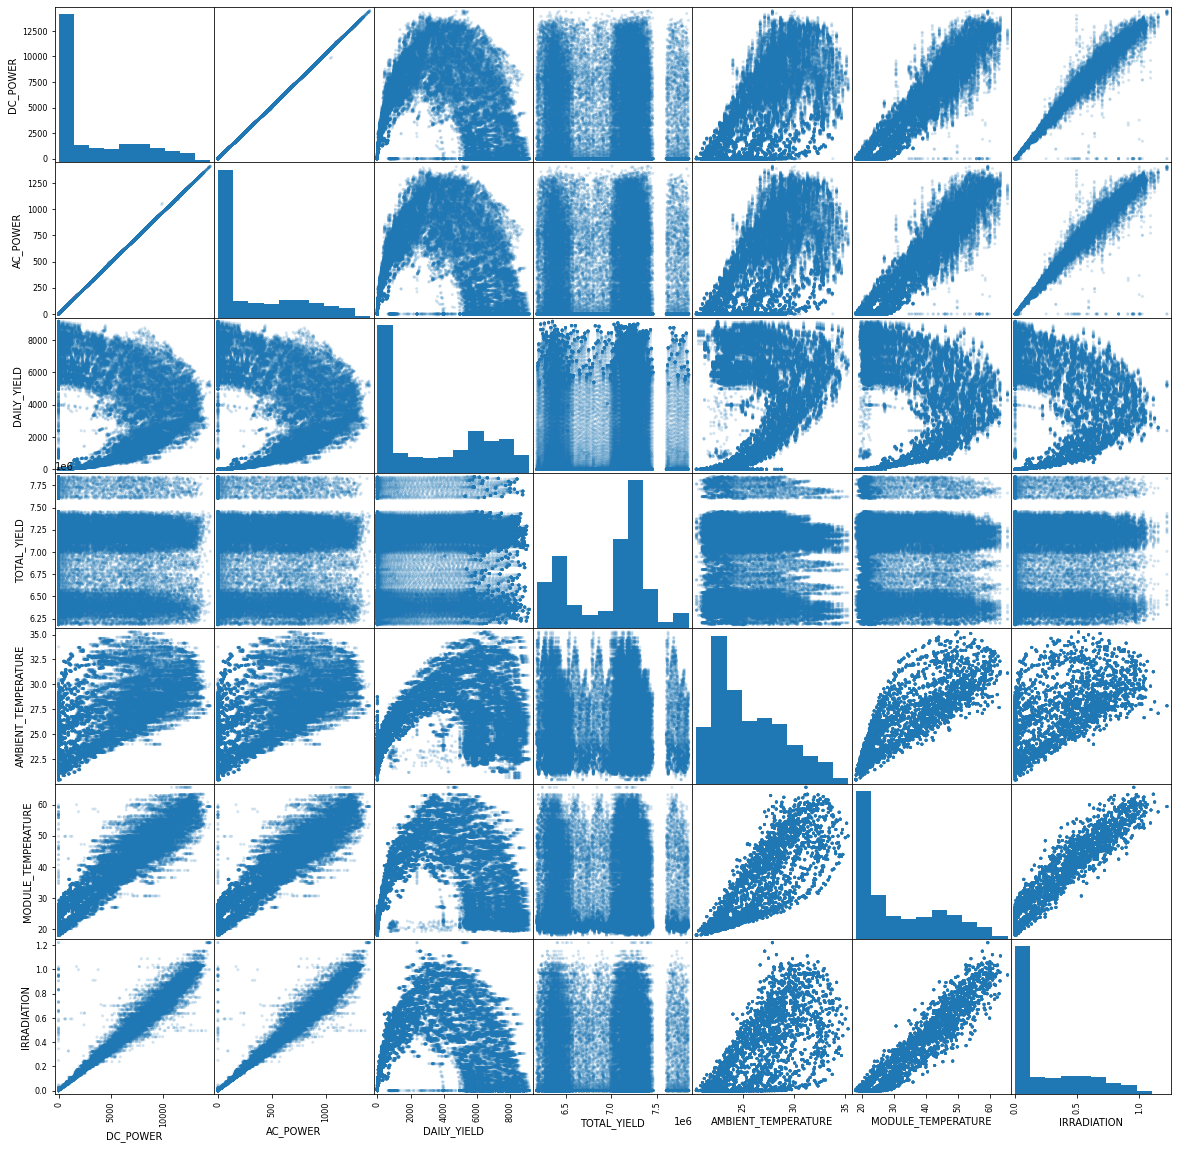

In [16]:
pd.plotting.scatter_matrix(trimmed, figsize=(20,20), alpha=0.2)
plt.show()

In [17]:
trimmed.corr()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DC_POWER,1.000000,0.999996,0.082243,0.003851,0.724668,0.954811,0.989391
AC_POWER,0.999996,1.000000,0.082193,0.003840,0.724903,0.954924,0.989340
DAILY_YIELD,0.082243,0.082193,1.000000,0.009896,0.478496,0.198308,0.078317
TOTAL_YIELD,0.003851,0.003840,0.009896,1.000000,-0.036150,-0.015596,-0.005490
AMBIENT_TEMPERATURE,0.724668,0.724903,0.478496,-0.036150,1.000000,0.855420,0.725278
MODULE_TEMPERATURE,0.954811,0.954924,0.198308,-0.015596,0.855420,1.000000,0.961511
IRRADIATION,0.989391,0.989340,0.078317,-0.005490,0.725278,0.961511,1.000000


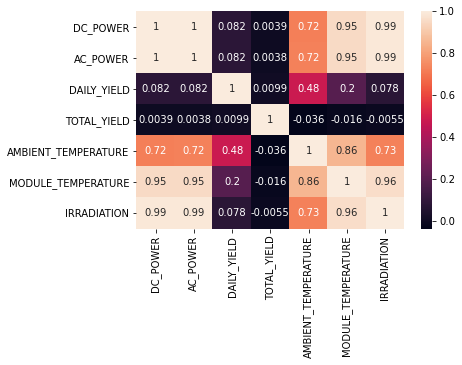

In [18]:
sns.heatmap(trimmed.corr(), annot=True)

From the two above graphs, it can be seen that there is strong correlations between AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION AND AC_POWER AND DC_POWER. This is a useful piece of information to build models. 

## EDA Summary

Let's sum up what the steps are for data cleaning so we can start building a transforming pipeline:
- Join weather and gen_df to detect more patterns in the datasets
- Drop source key in weather
- Drop plant id in both
- Drop all rows with nan values as they do not have much impact on the model performance
- Drop DATE_TIME column for now as it requires more time and effort to transform it into something useful
- Scale values

Since the correlation between TOTAL_YIELD and other variables are pretty low, I will attempt to predict the values of column DAILY_YIELD. This can be done in two ways:  
- Using all the features there are in the dataset
- Using weather data to predict the AC and DC power generation, then use those predicted values to estimate the values for DAILY_YIELD, as they all have high correlation coefficients.  
  
However, I will just experiment with the first way, as it is a bit simpler and more straightforward.

# Data Preparation

## Pipeline

Build a transformation pipeline to automate the process of data transforming. The original datasets are pretty clean, so the pipeline does not have to do much except dropping unnecessary columns and rows with nan values, which are not many. A ColumnTransformer is used for the former task, and I will have to define 2 functions (one for dropping rows and one for testing the result) for the latter task.

In [19]:
def drop_rows_with_nan(a):
    return a[~np.isnan(a).any(axis=1)]

In [21]:
def has_no_nan(a):
    return np.isnan(a).any() == False

Now comes the transformers and our pipeline:

In [22]:
column_transform = ColumnTransformer(
    [('drop_cols', 'drop', drop_cols)],
    remainder='passthrough'
)
entries_cleaning = FunctionTransformer(drop_rows_with_nan, has_no_nan)
minmax_scaler = MinMaxScaler()

full_pipeline = Pipeline([
    ('drop_cols', column_transform),
    ('drop_missing_rows', entries_cleaning),
    #('scaler', minmax_scaler)
])

joined_prepared = full_pipeline.fit_transform(joined)

## Split train and test sets

After the dataset has been transformed, the next step is to split it into train and test sets to prepare for building the models:

In [23]:
joined_prepared_df = pd.DataFrame(joined_prepared, columns=trimmed.columns)
joined_prepared_df

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,0.0,0.0,0.000,6259559.0,25.184316,22.857507,0.0
1,0.0,0.0,0.000,6183645.0,25.184316,22.857507,0.0
2,0.0,0.0,0.000,6987759.0,25.184316,22.857507,0.0
3,0.0,0.0,0.000,7602960.0,25.184316,22.857507,0.0
4,0.0,0.0,0.000,7158964.0,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...
68769,0.0,0.0,5967.000,7287002.0,21.909288,20.427972,0.0
68770,0.0,0.0,5147.625,7028601.0,21.909288,20.427972,0.0
68771,0.0,0.0,5819.000,7251204.0,21.909288,20.427972,0.0
68772,0.0,0.0,5817.000,6583369.0,21.909288,20.427972,0.0


In [24]:
target = joined_prepared_df.DAILY_YIELD
predictors = joined_prepared_df.drop(['DAILY_YIELD'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(predictors, target)

# Model selection and fine-tuning

Let's define a helper function to speed up the process of evaluating the models

In [25]:
def rmse_evaluation_on_test_set(reg):
    pred = reg.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, pred))

## Linear Regression

I will score how this algorithm performs on this data set using the cross validation method as below:

In [43]:
lin_cv_scores = cross_val_score(LinearRegression(), X_train, y_train,
                                scoring='neg_mean_squared_error', cv=10)
lin_cv_rmse = np.sqrt(-lin_cv_scores)
lin_cv_rmse

array([2449.70975796, 2392.60915674, 2396.9763192 , 2457.37123538,
       2447.7110539 , 2467.92502912, 2402.57920974, 2444.76799732,
       2415.25246454, 2443.3478788 ])

Here is the general score, which has a quite small standard deviation:

In [44]:
lin_cv_rmse.mean()

2431.8250102700367

In [45]:
lin_cv_rmse.std()

25.904882805147395

Here is some stats about the training labels to compare:

In [29]:
y_train.describe()

count    51580.000000
mean      3293.967406
std       3145.651668
min          0.000000
25%          0.000000
50%       2660.142857
75%       6274.000000
max       9163.000000
Name: DAILY_YIELD, dtype: float64

The performance of this model is pretty low. As you can see, the RMSE score is around 2400 on average, while the mean value of the label is already around 3300. However, let's see how it performs on the test set:

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)
lin_pred_mse = mean_squared_error(y_test, lin_pred)
lin_pred_rmse = np.sqrt(lin_pred_mse)
lin_pred_rmse

2419.6263170229936

Well, at least the performance of this model is pretty consistant in both train and test set. However, it is not good enough, so let's experiment with some other regression algorithms.

## SGD Regression

This algorithm tends to require a lot of hyperparameters tuning, so I suppose a Randomized Search could come in handy.

In [31]:
random_search_params = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': expon(scale=0.001).rvs(100),
    'l1_ratio': expon(scale=0.01).rvs(100),
    'max_iter': [10,100,500,700,1000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

lin_sgd_random_search = RandomizedSearchCV(SGDRegressor(), random_search_params,
                                            n_iter=100, scoring='neg_mean_squared_error',
                                            return_train_score=True)
lin_sgd_random_search.fit(X_train, y_train);

There are several thousands of hyperparameter combinations in this case, which can take a while to run, but for the sake of experimentality, I just ran the search with 100 iterations. Now, let's have a look at the best score on the train set:

In [50]:
np.sqrt(-lin_sgd_random_search.best_score_)

1182683.631821602

Wow, somehow this is even worse than the Linear Regressor above. Let's see how it performs on the test set:

In [33]:
lin_sgd = lin_sgd_random_search.best_estimator_
rmse_evaluation_on_test_set(lin_sgd)

4101.1484915400715

Again, not good enough. Let's see about tree-based algorithms.

## Decision Tree and Random Forest Regressors

In [34]:
tree_grid_search_params = {
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,None],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3],
}

tree_grid_search = GridSearchCV(DecisionTreeRegressor(), tree_grid_search_params, 
                                scoring='neg_mean_squared_error', return_train_score=True)
tree_grid_search.fit(X_train, y_train);

Here's the score of the best tree on our train set:

In [36]:
np.sqrt(-tree_grid_search.best_score_)

1079.2716301782891

Let's see how it performs on the test set as well:

In [37]:
best_tree = tree_grid_search.best_estimator_
rmse_evaluation_on_test_set(best_tree)

1026.6233958968894

So that's the performance of a single tree, which is undoubtedly a considerable improvement compared to the Linear Regression model above. Now let's see if a combination of trees can outperform it:

In [42]:
rfr_grid_search_params = {
    'n_estimators': [10,20,50],
    'max_depth': [2,3,4,5,None],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3]
}

rfr_grid_search = GridSearchCV(RandomForestRegressor(), rfr_grid_search_params, 
                                scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
rfr_grid_search.fit(X_train, y_train);

RMSE score of the forest on the train set:

In [46]:
np.sqrt(-rfr_grid_search.best_score_)

854.1369677871166

RMSE score on the test set:

In [48]:
best_rfr = rfr_grid_search.best_estimator_
rmse_evaluation_on_test_set(best_rfr)

770.089956532496

The difference is not much, but it certainly is an improvement. Let's store this model so we can investigate more or deploy it into production mode in the future. For that, I use a library named pickle:

In [49]:
with open("rfr_DAILY_YIELD.pkl", "wb") as fh:
    fh = pickle.dump(best_rfr, fh)

# Conclusion

This is certainly not a very detailed analysis, but the results seem to be promising, especially with tree-based algorithms. Should there be more time for enriching the datasets as well as more computing resource to experiment with more models and feature combinations, I am pretty positive that the performance of the final model can be much better. 